# Optimization

In this tutorial, we will show you how to perform gradient based optimization with `ConvDo`.

<a target="_blank" href="https://colab.research.google.com/github/qiauil/ConvDO/blob/main//docs/contents/examples/optimization.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Let's start with `divergence` again. You may notice that the divergence of the Kolmogorov flow is not such perfect in the [Divergence Operator](https://colab.research.google.com/github/qiauil/ConvDO/blob/main//docs/contents/examples/divergence.ipynb) tutorial. Thanks to PyTorch, all the operation is differentiable. Thus, we can directly use gradient descent method to make the flow field more divergence free.

## Make it more divergence free

First, Let's build the operator and load the dataset as we have done before:

In [2]:
import torch
import matplotlib.pyplot as plt
from ConvDO import *

class Divergence(FieldOperations):
    
    def __init__(self, 
                 domain_u:Domain,
                 domain_v:Domain,
                 order:int, 
                 device="cpu", 
                 dtype=torch.float32) -> None:
        super().__init__(order, device, dtype)
        self.velocity=VectorValue(ScalarField(domain=domain_u),ScalarField(domain=domain_v))
        
    def __call__(self, u:torch.Tensor,v:torch.Tensor):
        self.velocity.ux.register_value(u)
        self.velocity.uy.register_value(v)
        return (self.nabla@self.velocity).value

flow= torch.load('../../binaries/kf_flow.pt')
u=flow[0]
v=flow[1]
domain=PeriodicDomain(delta_x=2*3.14/64,delta_y=2*3.14/64)
divergence=Divergence(domain_u=domain,domain_v=domain,order=6)

Now, let's have a check on the residual of divergence before optimization:

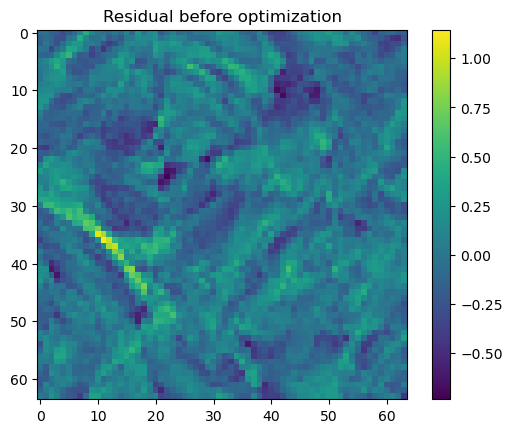

In [3]:
channel_names=["u","v"]
residual=divergence(u,v)
plt.imshow(residual.detach().numpy().squeeze().squeeze())
plt.colorbar()
plt.title("Residual before optimization")
plt.show()

We can decrease the divergence residual with the gradient descent optimization as we usually do for training a neural network:

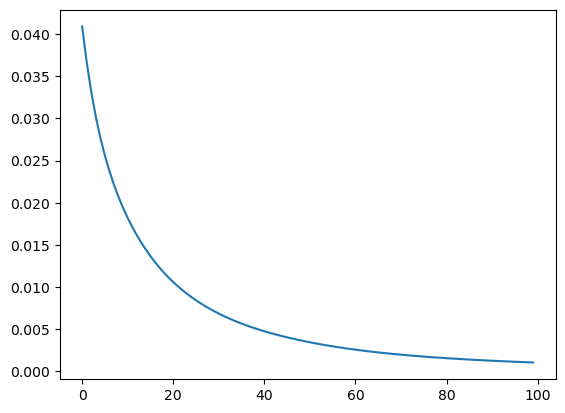

In [4]:
losses=[]
optimizer = torch.optim.Adam([u,v],lr=0.001)
u.requires_grad=True
v.requires_grad=True

for i in range(100):
    optimizer.zero_grad()
    residual=divergence(u,v)
    loss=torch.mean(residual**2)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    
plt.plot(losses)
plt.show()

Now, its time to check on the result!

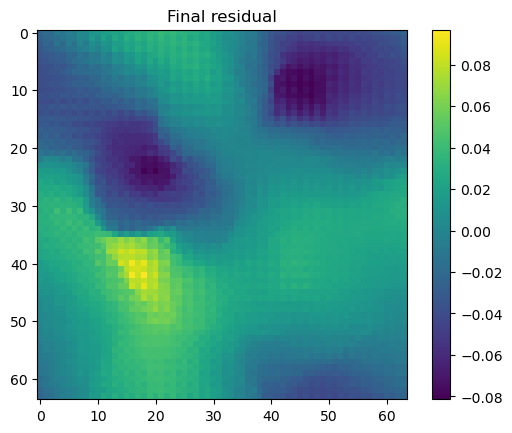

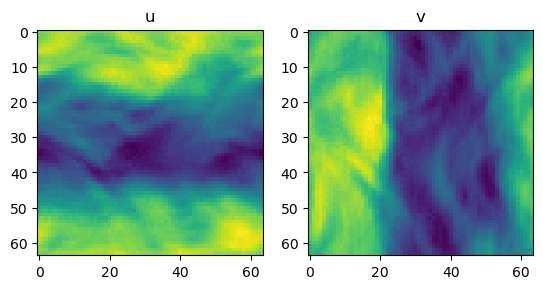

In [5]:
plt.imshow(residual.detach().numpy().squeeze().squeeze())
plt.colorbar()
plt.title("Final residual")
plt.show()
fig, axs = plt.subplots(1, 2)
for i, ax in enumerate(axs):
    ax.imshow(flow[i].detach().numpy())
    ax.set_title(channel_names[i])
plt.show()

## Solve PDEs

We could also use `ConvDO` to solve some PDEs with gradient descent. For example, we could solve the [2D lid-driven cavity flow](https://www.researchgate.net/publication/324413434_The_Lid-Driven_Cavity):

$$
\left\{\begin{matrix}
 {u {{\partial u} \over {\partial x}}} + v {{\partial u} \over {\partial y}} = -{{\partial p} \over {\partial x}} + \frac{1}{Re} \left( {{\partial^2 u} \over {\partial x^2}} + {{\partial^2 u} \over {\partial y^2}} \right)

 \\
{u {{\partial v} \over {\partial x}}} + v {{\partial v} \over {\partial y}} = -{{\partial p} \over {\partial y}} + \frac{1}{Re} \left( {{\partial^2 v} \over {\partial x^2}} + {{\partial^2 v} \over {\partial y^2}} \right)

\\
\frac{\partial u}{\partial x}+\frac{\partial v}{\partial y}=0
\end{matrix}\right.
$$

where $Re=\frac{u_c l}{\nu}$ is the Reynolds number. In the lid-driven cavity flow case, $u_c$ is the velocity of the upper boundary, $l$ is the side length of the domain. The operator of these equations can be defined as:

In [7]:
class SteadyNS(FieldOperations):
    
    def __init__(self, Re:float,
                 domain_u:Domain,
                 domain_v:Domain,
                 domain_p:Domain,
                 order=2, 
                 device="cpu",
                 dtype=torch.float32) -> None:
        super().__init__(order, device, dtype)
        self.velocity=VectorValue(ScalarField(domain=domain_u),ScalarField(domain=domain_v))
        self.pressure=ScalarField(domain=domain_p)
        self.Re=Re
        
    def __call__(self, 
                 u:torch.Tensor,
                 v:torch.Tensor,
                 p:torch.Tensor,):
        self.velocity.ux.register_value(u)
        self.velocity.uy.register_value(v)
        self.pressure.register_value(p)

        viscosity=self.nabla2*self.velocity*(1/self.Re)
        momentum_x=self.grad_x*self.velocity.ux*self.velocity.ux+self.grad_y*self.velocity.ux*self.velocity.uy+self.grad_x*self.pressure-viscosity.ux
        momentum_y=self.grad_x*self.velocity.uy*self.velocity.ux+self.grad_y*self.velocity.uy*self.velocity.uy+self.grad_y*self.pressure-viscosity.uy
        divergence=self.nabla@self.velocity
        
        return momentum_x.value.abs(),momentum_y.value.abs(),divergence.value.abs()

Now, Let's define the domain of the velocity and pressure:

In [8]:
N=128

domain_u=Domain(
    boundaries=[
        DirichletBoundary(0.0),
        DirichletBoundary(0.0),
        DirichletBoundary(1.0),
        DirichletBoundary(0.0)],
    delta_x=1.0/N,
    delta_y=1.0/N,)

domain_v=Domain(boundaries=[DirichletBoundary(0.0)]*4,
                delta_x=1.0/N,
                delta_y=1.0/N,)

domain_p=Domain(boundaries=[NeumannBoundary(0.0)]*4,               
                delta_x=1.0/N,
                delta_y=1.0/N,)


Optimization start!

Loss: 38689.418: 100%|██████████| 50000/50000 [06:18<00:00, 132.26it/s]


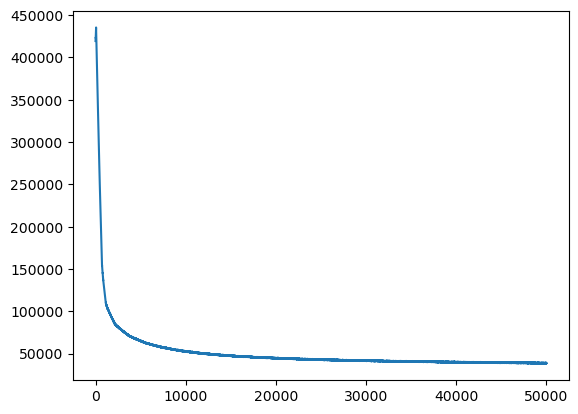

In [9]:
from tqdm import tqdm

operator=SteadyNS(10,domain_u,domain_v,domain_p,order=2)        
uvp=torch.zeros((3,N,N),requires_grad=True)
# Working on GPU:
#operator=SteadyNS(10,domain_u,domain_v,domain_p,order=2,device="cuda")        
#uvp=torch.zeros((3,N,N),requires_grad=True,device="cuda")
optimizer = torch.optim.Adam([uvp],lr=0.001)
losses=[]

p_bar=tqdm(range(50000))
for i in p_bar:
    optimizer.zero_grad()
    m_x,m_y,c=operator(uvp[0],uvp[1],uvp[2])
    loss=m_x.sum()+m_y.sum()+c.sum()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    p_bar.set_description("Loss: {:.3f}".format(loss.item()))
plt.plot(losses)


Now, lets visualize the results:

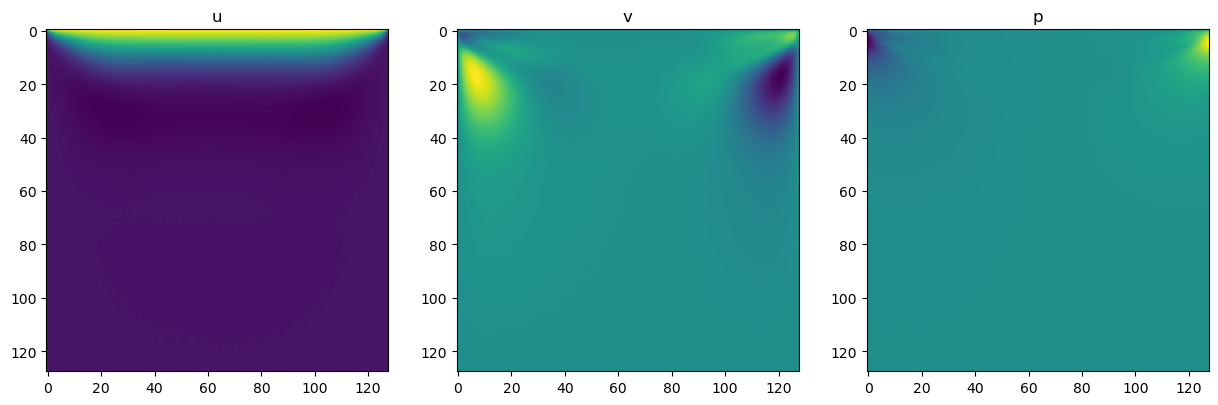

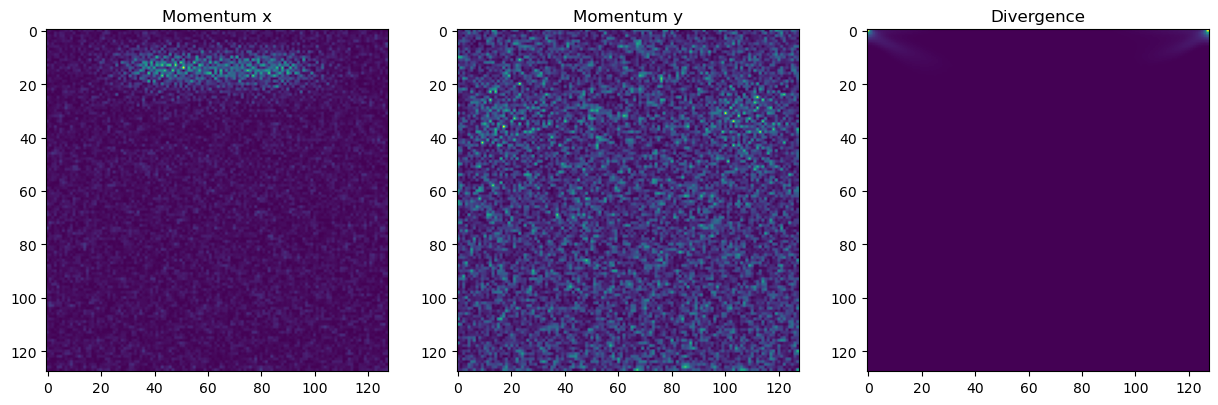

In [12]:
channel_names=["u","v","p"]
fig,ax=plt.subplots(1,3,figsize=(15,5))
for i in range(3):
    ax[i].imshow(uvp[i].detach().numpy())
    #ax[i].imshow(uvp[i].cpu().detach().numpy())
    ax[i].set_title(channel_names[i])
plt.show()

channel_names=["Momentum x","Momentum y","Divergence"]
residuals=operator(uvp[0],uvp[1],uvp[2])
fig,ax=plt.subplots(1,3,figsize=(15,5))
for i in range(3):
    #ax[i].imshow(residuals[i].cpu().detach().numpy().squeeze().squeeze())
    ax[i].imshow(residuals[i].detach().numpy().squeeze().squeeze())
    ax[i].set_title(channel_names[i])

plt.show()

Cool, we successfully get the flow field inside the cavity. In real applications, you may want to use a neural network to train a surrogate model for the flow simulator rather than directly optimize the field. This is also easy to be done with `ConvDO`, you can have a try by yourself. Enjoy!